## Create and test ion channel model

In [1]:
from experiments.ica_Li import (Li_iv_80,
                               Li_iv_60,
                                Li_iv_40,
                               Li_act,
                               Li_inact_1000,
                                Li_inact_300,
                                Li_inact_150,
                                Li_inact_kin_40,
                                Li_inact_kin_60,
                                Li_inact_kin_80,
                                Li_recov_80
                               )

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.4


In [2]:
modelfile = 'models/nygren_IcaL.mmt'

In [3]:
observations, model, summary_statistics = setup(modelfile,
                                                Li_inact_kin_80
                                               )

In [4]:
assert len(observations)==len(summary_statistics(model({})))

## Set limits and generate uniform initial priors

In [17]:

# 
#'membrane.Cm' : (0.0001,1), # keep it off 

limits = {'i_caL.p1': (0,50),
          'i_caL.p2': (-20,20),
          'log_i_caL.p3': (-7,-2),
          'i_caL.p4': (20,80),
          'i_caL.p5': (20,80),
          'log_i_caL.p6': (-7,-2),
          'i_caL.q1': (10,50),
          'i_caL.q2': (-20,20),
          'log_i_caL.q3': (-4,1),
          'i_caL.q4': (20,80),
          'i_caL.q5': (-25,25),
          'log_i_caL.q6': (-5,-1),
          'log_i_caL.r1': (-2,1),
          'i_caL.r2': (-25,50),
          'i_caL.r3': (-30,30),
          'log_i_caL.r4': (0,100)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [6]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "nygren_icaL_testing.db"))

In [7]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [8]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 65536 particles


In [18]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(10000), #Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.696619050993233, '1': 0.6325397167009171, '2': 0.5575816795491062, '3': 0.633662918067022, '4': 0.33184187663063536, '5': 0.7712384897779926, '6': 1.157867275754697, '7': 0.7242645596332606, '8': 4.163562092098057, '9': 0.3308223407950784}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=20, quantile_multiplier=1


In [19]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [20]:
#abc.load(db_path,1)

In [21]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=3, start_time=2019-08-20 15:57:29.160813, end_time=None)>


In [23]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10, min_acceptance_rate=0.005)

INFO:ABC:t:6 eps:3.094250057832163
DEBUG:ABC:now submitting population 6
Process Process-207:
Process Process-214:
Process Process-210:
Process Process-211:
Process Process-212:
Traceback (most recent call last):
  File "/apps/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/apps/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/apps/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
Process Process-206:
  File "/apps/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process Process-209:
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/smc.py", line 545, in simulate_one
    transitions)
Traceback (most recent call last):
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work

  File "/home/brm18/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py", line 1723, in pdf
    cond = cond0 & cond1
KeyboardInterrupt
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
  File "/apps/anaconda3/lib/python3.7/site-packages/pandas/core/nanops.py", line 319, in nanany
    values, mask, dtype, _ = _get_values(values, skipna, False, copy=skipna)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionmeta.py", line 37, in rvs_single
    return f(self)
KeyboardInterrupt
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/smc.py", line 545, in simulate_one
    transitions)
Traceback (most recent call last):
  File "/apps/anaconda3/lib/python3.7/site-packages/pandas/core/nanops.py", line 212, in _get_values
    mask = isna(values)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/multivariatenormal.py", l

  File "/apps/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 3425, in fillna
    **kwargs)
  File "/apps/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py", line 5436, in fillna
    return self._constructor(new_data).__finalize__(self)
  File "/apps/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py", line 4359, in __finalize__
    object.__setattr__(self, name, getattr(other, name, None))
  File "/apps/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 401, in name
    @property
KeyboardInterrupt
  File "/apps/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/smc.py", line 560, in simulate_one
    transitions)
  File "/home/brm18/.local/lib/python3.7/site-pa

# Results analysis

In [14]:
#history.all_runs()

/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/

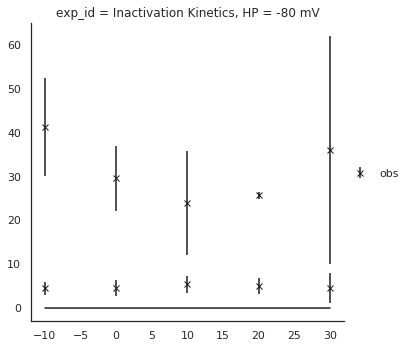

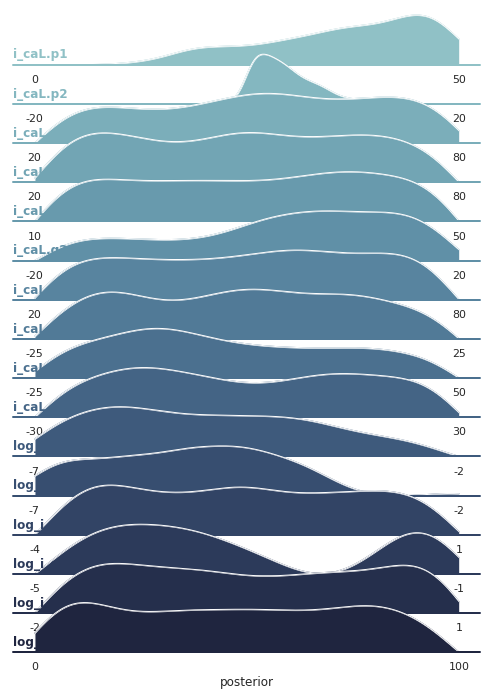

In [24]:
history = History(db_path)
history.id = 3 #(3 corresponds to the inactivation kinetics )
df, w = history.get_distribution(m=0)

grid1 = plot_sim_results(modelfile,Li_inact_kin_80,df=df, w=w) 
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

In [ ]:
grid2.savefig('results/ina_nygren_posterior_recovery_saka_pop_10000.pdf')
grid1.savefig('results/ina_nygren_experiments_recovery_saka__pop_10000.pdf')